In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import LMC
import imp
import astropy.stats
import scipy.signal as sig
import scipy.optimize as op
import dcor

from scipy import stats

from sklearn.cluster   import KMeans
from sklearn.cluster   import SpectralClustering
from sklearn.neighbors import DistanceMetric

pi = np.pi

MSME = 332948.6                            # (M_sun/M_earth)


RNRE = 3.8647      # (Rnep/Rearth)
RJRE = 10.973      # (Rjup/Rearth)
RSRE = 109.2       # (Rsun/Rearth)

RSRN = RSRE/RNRE   # (Rsun/Rnep)
RSRJ = RSRE/RJRE   # (Rsun/Rjup)

BIGG = 6.67e-11    # Newton's constant [SI units]

RSUN = 6.957e8     # solar radius [m]
MSUN = 1.988e30    # Solar mass [kg]

GSUN = BIGG / RSUN**3 * MSUN * (24*3600)**2    # Newton's constant [R_sun^3 * M_sun^-1 * days^-2]

# Read in CKS data

In [2]:
# READ IN CKS DATABASE
# documentation of csv file found at http://www.astro.caltech.edu/~howard/cks/column-definitions.txt

cks_file = '/Users/research/Desktop/dinosaur/clean_maiasaurus_catalogue.csv'

cks_data = []
with open(cks_file) as infile:
    reader = csv.reader(infile)
    
    for row in reader:
        cks_data.append(row)
        
KEYS = cks_data[0]
VALUES = cks_data[1:]

def getkey(keyname,keys=KEYS,values=VALUES):
    '''
    keyname = (string) of column definition, see CKS documentation
    '''
    kid = keys.index(keyname)
    
    dummy = []
    for row in values:
        dummy.append(row[kid])
    
    return dummy

In [3]:
# PULL RELEVANT QUANTITIES FROM CKS
d = {}

d['starname']    = getkey('id_starname')             # star id - 'K00082'
d['koi']         = getkey('id_koicand')
d['kic']         = getkey('id_kic')                  # Kepler Input Catalogue ID
d['disposition'] = getkey('koi_disposition')         # status - 'CONFIRMED', 'CANDIDATE', 'FALSE POSITIVE', etc.
d['falsepos']    = getkey('cks_fp')                  # CKS false positive designation - 'False' or 'True'
d['snr']         = getkey('koi_model_snr')           # transit signal-to-noise
d['npl']         = getkey('koi_count')               # number of planets in system

d['period']      = getkey('koi_period')              # period (days)
d['period_err1'] = getkey('koi_period_err1')
d['period_err2'] = getkey('koi_period_err2')

d['rprs']      = getkey('koi_ror')                   # planet-to-star radius ratio
d['rprs_err1'] = getkey('koi_ror_err1')
d['rprs_err2'] = getkey('koi_ror_err2')

d['impact']      = getkey('koi_impact')              # impact parameter
d['impact_err1'] = getkey('koi_impact_err1')
d['impact_err2'] = getkey('koi_impact_err2')

d['koi_duration']      = getkey('koi_duration')      # transit duration (hours)
d['koi_duration_err1'] = getkey('koi_duration_err1')
d['koi_duration_err2'] = getkey('koi_duration_err2')

d['rp']      = getkey('iso_prad')                    # CKS+isochrone constrained planet radius (earth radius)
d['rp_err1'] = getkey('iso_prad_err1')
d['rp_err2'] = getkey('iso_prad_err2')

d['sma']      = getkey('iso_sma')                    # CKS+isochrone constrained semi-major axis (AU)
d['sma_err1'] = getkey('iso_sma_err1')
d['sma_err2'] = getkey('iso_sma_err2')

d['rstar']      = getkey('iso_srad')                 # CKS+isochrone constrained stellar radius (solar radius)
d['rstar_err1'] = getkey('iso_srad_err1')
d['rstar_err2'] = getkey('iso_srad_err2')

d['mstar']      = getkey('iso_smass')                # CKS+isochrone constrained stellar mas (solar mass)
d['mstar_err1'] = getkey('iso_smass_err1')
d['mstar_err2'] = getkey('iso_smass_err2')

d0 = d.copy()

In [4]:
# QUICKLY CLEAN DATA

d = d0.copy()

KEY0 = 'starname'

def check_lengths(d, key0=KEY0):
    '''
    checks that all data arrays are the same length
    '''
    keys = d.keys()    
    L0   = len(d[key0])
        
    for k in keys:
        if len(d[k]) != L0: raise ValueError('inconsistent array length for array "%s"' %k)
            
    return None


def convert_to_arrays(d):
    keys = d.keys()
    dnew = {}
    
    for k in keys:
        dnew[k] = np.asarray(d[k])
        
    return dnew

    
    
def remove_missing_data(d, key0=KEY0):
    '''
    removes empty data cells
    '''
    keys = d.keys()
    L0   = len(d[key0])
    dnew = {}
    
    empty = np.zeros(L0)
    
    for k in keys:
        empty += d[k] == ''
    
    empty = empty > 0.0

    for k in keys:
        dnew[k] = d[k][~empty]

    check_lengths(dnew)
    
    return dnew


# CLEAN DATA
d = convert_to_arrays(d)
print('total number of queried objects =', len(d[KEY0]))

d = remove_missing_data(d)
print('after removing missing data, number of objects =', len(d[KEY0]))

check_lengths(d)

total number of queried objects = 1072
after removing missing data, number of objects = 1072


In [5]:
# CONVERT STRINGS TO FLOATS
def is_number(s):
    '''
    checks if input string s is a number
    '''
    try:
        float(s)
        return True
    except ValueError:
        return False
    
def convert_floats(d):
    '''
    converts numerical arrays from strings to floats
    '''
    keys = d.keys()
    dnew = {}
    
    for k in keys:
        if is_number(d[k][0]):
            dnew[k] = np.asarray(d[k],dtype='float')
        else:
            dnew[k] = np.asarray(d[k])
    
    return dnew


# CONVERT STRINGS TO FLOATS (where applicable)
d = convert_floats(d)

# BACKUP COPY OF DATA
d1 = d.copy()


# Convert radius to mass

In [6]:
d = d1.copy()

# CONVERT RADIUS TO MASS
def radius_to_mass(R):
    '''
    converts radius (R_earth) to mass (M_earth) with a probabilistic M-R relation
    '''
    L0 = len(R)
    
    # apply the M-R relation of Wolfgang, Rogers, & Ford (2015) -- small/medium planets
    C = np.zeros(L0)
    y = np.zeros(L0)
    
    C[R<=1.6] = 1.4
    y[R<=1.6] = 2.3
        
    C[(R<=4.0)*(R>1.6)] = 2.7
    y[(R<=4.0)*(R>1.6)] = 1.3
    
    C[(R<=8.0)*(R>4.0)] = 1.6
    y[(R<=8.0)*(R>4.0)] = 1.8
    
    M = C*np.power(R,y)
    
    # scale mass of large planets linear with radius based on Saturn mass [BAD METHOD!!!]
    M[(R>8.0)] = 95.1608*R[R>8.0]/9.1402
    
    return M
    
d['mp'] = radius_to_mass(d['rp'])

d2 = d.copy()

# Calculate compexity metrics for each system

In [7]:
class System:
    def __init__(self, sysid=None):
        
        self.sysid = sysid

In [8]:
def P_to_a(P, Mstar):
    '''
    P: orbital periods [days]
    Mstar: stellar mass [solar masses]
    '''
    Pearth = 365.24    # [days]
    aearth = 215.05    # [solar radii]
    
    a = aearth * ((P/Pearth)**2 *(1/Mstar))**(1/3)
    
    return a

def transit_prob(a, Rstar):
    '''
    a: semi-major axis [solar radii]
    Rstar: stellar radius [solar radii]
    '''
    return Rstar/a

In [9]:
d = d2.copy()

uniquesys = np.unique(d['starname'])
systems   = []

for us in uniquesys:
    # initialize System() object
    s = System()
    
    # pull stellar data
    s.sysid   = us
    s.Mstar   = d['mstar'][d['starname']==us][0]
    s.Rstar   = d['rstar'][d['starname']==us][0]
    
    # pull planetary data
    s.rprs    = d['rprs'][d['starname']==us]
    s.masses  = d['mp'][d['starname']==us]
    s.periods = d['period'][d['starname']==us]

    # pull transit durations and errors, convert hrs to days
    s.dur     = d['koi_duration'][d['starname']==s.sysid]/24
    s.dur_err = 0.5*((d['koi_duration_err1'][d['starname']==s.sysid]) -
                     (d['koi_duration_err2'][d['starname']==s.sysid]))/24
    
    # sort masses, periods, and durations by period
    order = np.argsort(s.periods)
    
    s.rprs    = s.rprs[order]
    s.masses  = s.masses[order]
    s.periods = s.periods[order]
    s.dur     = s.dur[order]
    s.dur_err = s.dur_err[order]
    
    
    # calculate N and mu
    s.N  = len(s.masses)
    s.mu = np.sum(s.masses)/s.Mstar/MSME
    
    # calcuate Q
    s.Q = LMC.D(s.masses/np.sum(s.masses))
    
    # calculate C
    if s.N < 3:
        s.C = np.nan
    elif s.N >= 3:
        P  = s.periods
        pp = np.log(P[1:]/P[:-1])/np.log(P.max()/P.min())
        s.C = LMC.C(pp)
            
    # calculate Hill spacing
    P = s.periods
    a = P_to_a(P, s.Mstar)
    m = s.masses
    
    radius_H = ((m[1:]+m[:-1])/(3*s.Mstar*MSME))**(1/3) * (a[1:]+a[:-1])/2
    delta_H  = (a[1:]-a[:-1])/radius_H
    
    # calculate S:
    #s.S = np.log(P.max()/P.min())/(s.N-1)
    s.S = np.mean(delta_H)
    
    # calculate M
    M_spearmanr = stats.spearmanr(s.periods, s.masses)
    s.M = M_spearmanr[0] * (s.Q)**(1/s.N)
    
    systems.append(s)

In [10]:
Nsys = len(uniquesys)

N  = np.zeros(Nsys)
mu = np.zeros(Nsys)
Q  = np.zeros(Nsys)
C  = np.zeros(Nsys)
S  = np.zeros(Nsys)
M  = np.zeros(Nsys)


for i, s in enumerate(systems):
    N[i]  = s.N
    mu[i] = s.mu
    Q[i]  = s.Q
    C[i]  = s.C
    S[i]  = s.S
    M[i]  = s.M

logmu = np.log10(mu)

# Calculate flatness

In [11]:
def calculate_duration(period, G, rho, rprs, cosi):
    term3  = ((3*period)/(G*rho*pi**2))**(1/3)
    term2a = (1+rprs)**2
    term2b = ((G*rho)/(3*pi))**(2/3)
    term2c = period**(4/3)*cosi**2
    term2  = (term2a - term2b*term2c)**(1/2)
    
    return term3*term2


def residuals_for_duration_fit(x0, x1, data_dur, data_err):
    cosi = x0
    period, G, rho, rprs = x1
    
    model_dur = calculate_duration(period, G, rho, rprs, cosi)
    
    return (data_dur - model_dur)/data_err


def calculate_flatness(data_dur, model_dur):
    return np.std(data_dur-model_dur)/np.sqrt(np.mean(data_dur**2))

In [12]:
f  = np.zeros(Nsys)

for i, s in enumerate(systems):    
    # get stellar density [M_sun/R_sun^3]
    rhostar = s.Mstar/(4/3*pi*s.Rstar**3)
    
    # fit for duration
    cosi = np.array([0.0])
    transit_params = [s.periods, GSUN, rhostar, s.rprs]
        
    cosi, success = op.leastsq(residuals_for_duration_fit, cosi, args=(transit_params, s.dur, s.dur_err))
        
    plot_per = np.linspace(1,100)
    plot_dur = calculate_duration(plot_per, GSUN, rhostar, np.median(s.rprs), cosi)
    zero_inc_plot_dur = calculate_duration(plot_per, GSUN, rhostar, np.median(s.rprs), 0.0)

    model_dur = calculate_duration(s.periods, GSUN, rhostar, np.median(s.rprs), cosi)
    
    doplots = False
    if doplots:
        if s.N > 4:
            plt.figure()
            plt.errorbar(s.periods, 24*s.dur, yerr=24*s.dur_err, fmt='ko', fillstyle='none')
            plt.plot(plot_per, 24*plot_dur, 'r')
            plt.plot(plot_per, 24*zero_inc_plot_dur, 'k:')
            plt.xlim(1,100)
            plt.xscale('log')
            plt.show()
        
    s.f  = calculate_flatness(s.dur, model_dur)
    f[i] = s.f

/Users/research/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  


# Display gallery of systems

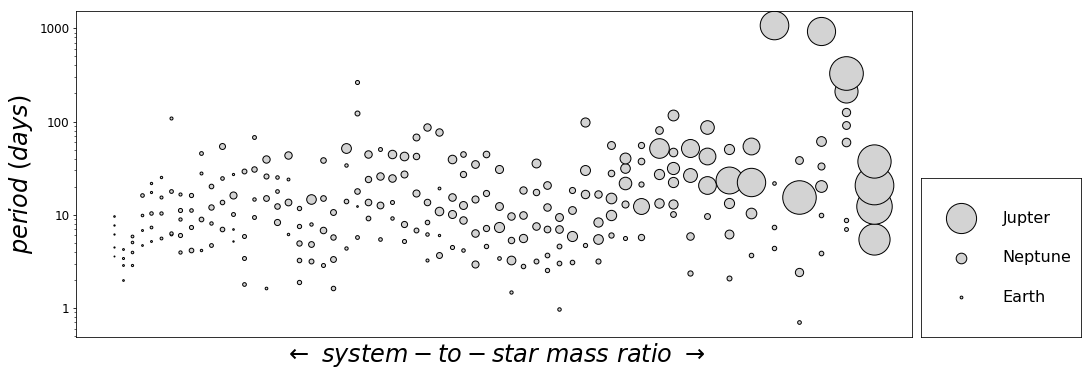

In [13]:
# determine ordering of systems
sys4 = []
mu4 = []
rp4 = []
for s in systems:
    if s.N >= 4:
        sys4.append(s)
        mu4.append(s.mu)
        rp4.append(np.max(s.rprs*s.Rstar))

        
sys4 = np.array(sys4)
mu4  = np.array(mu4)
rp4  = np.array(rp4)

order = np.argsort(mu4)
sys4 = sys4[order]
mu4  = mu4[order]
rp4  = rp4[order]

mu_rank = np.array(stats.rankdata(mu4)-1, dtype='int')
mu_pos  = 1.5*mu_rank + 30*np.cumsum(rp4)

plt.figure(figsize=(18,6))
plt.tight_layout()

ax1 = plt.subplot2grid((6,18),(0,0), rowspan=6, colspan=15)

for i, s in enumerate(sys4):
    for n in range(s.N):
        ax1.plot(mu_pos[i], s.periods[n], 'o', markersize=300*s.rprs[n]*s.Rstar, \
                 color='lightgrey', mec='k', mew=1)
        
ax1.set_xticks([])
ax1.set_xlabel(r'$\leftarrow\ system-to-star\ mass\ ratio\ \rightarrow$', fontsize=24)

ax1.set_yscale('log')
ax1.set_yticks([1,10,100,1000])
ax1.set_yticklabels([1,10,100,1000], fontsize=12)
ax1.set_ylabel(r'$period\ (days)$', fontsize=24)
            

ax2 = plt.subplot2grid((6,18),(3,15), rowspan=3, colspan=3)

ax2.plot(0.5, 0.95, 'o', markersize=300/RSRE, color='lightgrey', mec='k', mew=1)
ax2.plot(0.5, 1.10, 'o', markersize=300/RSRN, color='lightgrey', mec='k', mew=1)
ax2.plot(0.5, 1.25, 'o', markersize=300/RSRJ, color='lightgrey', mec='k', mew=1)


ax2.text(1.02, 0.95, 'Earth', va='center', fontsize=16)
ax2.text(1.02, 1.10, 'Neptune', va='center', fontsize=16)
ax2.text(1.02, 1.25, 'Jupter', va='center', fontsize=16)

ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_xlim(0,2)
ax2.set_ylim(0.8,1.4)

plt.show()

# Results for $\mathcal{Q}$ and $\mu$

In [14]:
# compare Q for 3 and 4+ planet systems
Q2 = Q[N==2]
Q3 = Q[N==3]
Q4 = Q[N>=4]

Q2 = np.sort(np.squeeze(Q2))
Q3 = np.sort(np.squeeze(Q3))
Q4 = np.sort(np.squeeze(Q4))

KS_Q32 = np.array(stats.ks_2samp(Q3,Q2))
KS_Q43 = np.array(stats.ks_2samp(Q4,Q3))


# compare mu for 3 and 4+ planet systems
logmu2 = logmu[N==2]
logmu3 = logmu[N==3]
logmu4 = logmu[N>=4]

logmu2 = np.sort(np.squeeze(logmu2))
logmu3 = np.sort(np.squeeze(logmu3))
logmu4 = np.sort(np.squeeze(logmu4))

KS_mu43  = np.array(stats.ks_2samp(logmu4,logmu3))
KS_mu32  = np.array(stats.ks_2samp(logmu3,logmu2))

mu4mu3 = np.median(10**logmu4)/np.median(10**logmu3)
mu3mu2 = np.median(10**logmu3)/np.median(10**logmu2)

In [15]:
# compare mu over N
mu_over_N = []

for i, s in enumerate(systems):
    mu_over_N.append(s.mu/s.N)

mu_over_N = np.array(mu_over_N)
    

logmu_over_N_2 = np.log10(mu_over_N[N==2])
logmu_over_N_3 = np.log10(mu_over_N[N==3])
logmu_over_N_4 = np.log10(mu_over_N[N>=4])

logmu_over_N_2 = np.sort(np.squeeze(logmu_over_N_2))
logmu_over_N_3 = np.sort(np.squeeze(logmu_over_N_3))
logmu_over_N_4 = np.sort(np.squeeze(logmu_over_N_4))

KS_mu_over_N_43  = np.array(stats.ks_2samp(logmu_over_N_4,logmu_over_N_3))
KS_mu_over_N_32  = np.array(stats.ks_2samp(logmu_over_N_3,logmu_over_N_2))

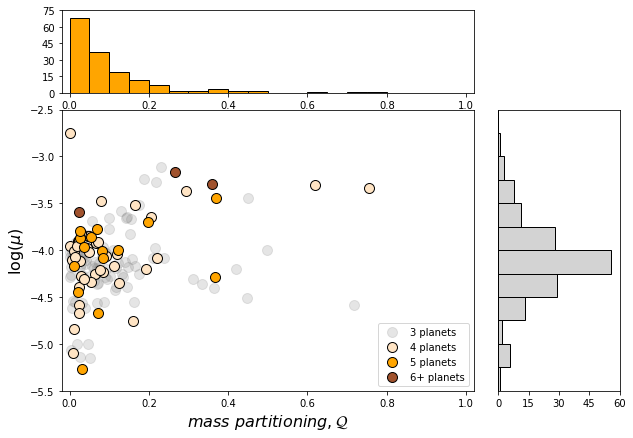

In [16]:
plt.figure(figsize=(10,7))
plt.tight_layout()

# Q vs mu scatter plot
ax1 = plt.subplot2grid((4,4),(1,0),colspan=3,rowspan=3)
plt.scatter(Q[N==3], logmu[N==3], c='grey',   alpha=0.2,     s=100, label='3 planets')
plt.scatter(Q[N==4], logmu[N==4], c='bisque', edgecolor='k', s=100, label='4 planets')
plt.scatter(Q[N==5], logmu[N==5], c='orange', edgecolor='k', s=100, label='5 planets')
plt.scatter(Q[N>=6], logmu[N>=6], c='sienna', edgecolor='k', s=100, label='6+ planets')
plt.xlim(-0.02,1.02)
plt.xlabel(r'$mass\ partitioning, \mathcal{Q}$',fontsize=16)
plt.ylim(-5.5,-2.5)
plt.ylabel(r'$\log(\mu)$',fontsize=16)
plt.legend(loc='lower right',frameon=True)


# Q historgram
ax1h = plt.subplot2grid((4,4),(0,0),colspan=3,rowspan=1)
plt.hist(Q[N>2], bins=np.arange(0.0,1.05,0.05), color='orange', edgecolor='black')
plt.xlim(-0.02,1.02)
plt.ylim(0,75)
plt.yticks([0,15,30,45,60,75])


# mu historgram
axsh = plt.subplot2grid((4,4),(1,3),colspan=1,rowspan=3)
plt.hist(logmu[N>2],bins=np.arange(-5.5,-2.25,0.25), \
         orientation='horizontal',color='lightgrey',edgecolor='black')
plt.yticks([])
plt.ylim(-5.5,-2.5)
plt.xticks([0,15,30,45,60])
plt.xlim(0,60)

#plt.savefig('/Users/research/Desktop/Figures/masspartitioning.pdf',bbox_inches='tight')
plt.show()

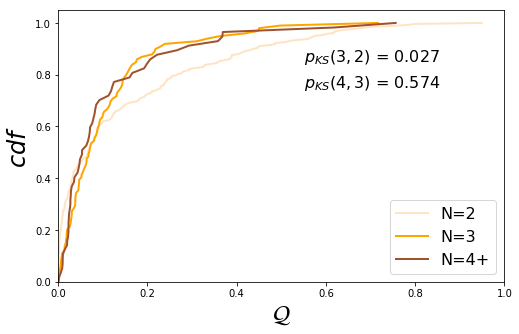

In [17]:
# plot Q
fig, ax = plt.subplots(1, figsize=(8,5))

ax.plot(Q2, np.linspace(0,1,len(Q2)), lw=2, color='bisque', label='N=2')
ax.plot(Q3, np.linspace(0,1,len(Q3)), lw=2, color='orange', label='N=3')
ax.plot(Q4, np.linspace(0,1,len(Q4)), lw=2, color='sienna', label='N=4+')
ax.set_xlim(0,1)
ax.set_xlabel(r'$\mathcal{Q}$', fontsize=24)
ax.set_ylim(0,1.05)
ax.set_ylabel(r'$cdf$', fontsize=24)

ax.text(0.55,0.85, r'$p_{KS}(3,2)$ = %.3f' %KS_Q32[1], fontsize=16, ha='left')
ax.text(0.55,0.75, r'$p_{KS}(4,3)$ = %.3f' %KS_Q43[1], fontsize=16, ha='left')
ax.legend(loc='lower right', fontsize=16)

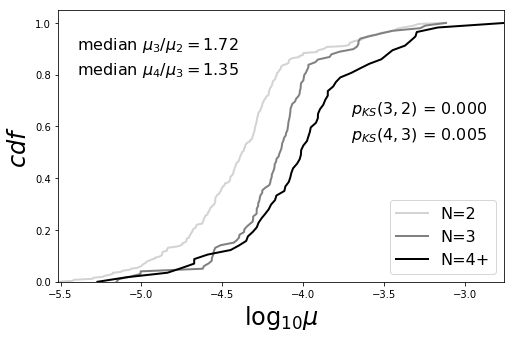

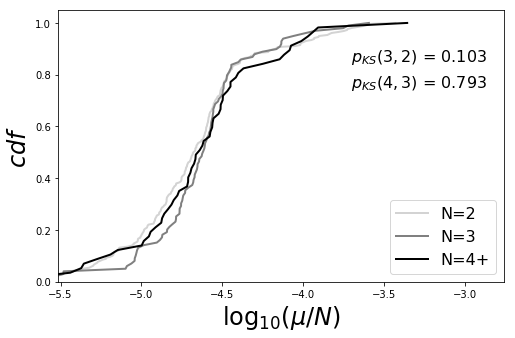

In [18]:
# plot mu
fig, ax = plt.subplots(1, figsize=(8,5))

ax.plot(logmu2, np.linspace(0,1,len(logmu2)), lw=2, color='lightgrey', label='N=2')
ax.plot(logmu3, np.linspace(0,1,len(logmu3)), lw=2, color='grey', label='N=3')
ax.plot(logmu4, np.linspace(0,1,len(logmu4)), lw=2, color='black', label='N=4+')
ax.set_xlim(logmu.min(),logmu.max())
ax.set_xlabel(r'$\log_{10}\mu}$', fontsize=24)
ax.set_ylim(0,1.05)
ax.set_ylabel(r'$cdf$', fontsize=24)

ax.text(-3.7,0.55, r'$p_{KS}(4,3)$ = %.3f' %KS_mu43[1], fontsize=16, ha='left')
ax.text(-3.7,0.65, r'$p_{KS}(3,2)$ = %.3f' %KS_mu32[1], fontsize=16, ha='left')
ax.text(-5.4,0.8, r'median $\mu_4/\mu_3 = %.2f$' %mu4mu3, fontsize=16, ha='left')
ax.text(-5.4,0.9, r'median $\mu_3/\mu_2 = %.2f$' %mu3mu2, fontsize=16, ha='left')
ax.legend(loc='lower right', fontsize=16)



# plot mu_over_N
fig, ax = plt.subplots(1, figsize=(8,5))
 
ax.plot(logmu_over_N_2, np.linspace(0,1,len(logmu_over_N_2)), lw=2, color='lightgrey', label='N=2')
ax.plot(logmu_over_N_3, np.linspace(0,1,len(logmu_over_N_3)), lw=2, color='grey', label='N=3')
ax.plot(logmu_over_N_4, np.linspace(0,1,len(logmu_over_N_4)), lw=2, color='black', label='N=4+')
ax.set_xlim(logmu.min(),logmu.max())
ax.set_xlabel(r'$\log_{10}(\mu/N)$', fontsize=24)
ax.set_ylim(0,1.05)
ax.set_ylabel(r'$cdf$', fontsize=24)

ax.text(-3.7,0.75, r'$p_{KS}(4,3)$ = %.3f' %KS_mu_over_N_43[1], fontsize=16, ha='left')
ax.text(-3.7,0.85, r'$p_{KS}(3,2)$ = %.3f' %KS_mu_over_N_32[1], fontsize=16, ha='left')
ax.legend(loc='lower right', fontsize=16)

# Results for $\mathcal{C}$ and $\mathcal{S}$ 

In [19]:
# 4- and 5-planet systems with second-to-last planet removed
P4 = 2**np.arange(4)
P5 = 2**np.arange(5)

P43 = P4[[0,1,3]]
P54 = P5[[0,1,2,4]]
P53 = P5[[0,1,4]]

pstar43 = np.log(P43[1:]/P43[:-1])/np.log(P43.max()/P43.min())
pstar54 = np.log(P54[1:]/P54[:-1])/np.log(P54.max()/P54.min())
pstar53 = np.log(P53[1:]/P53[:-1])/np.log(P53.max()/P53.min())


C43 = LMC.C(pstar43)
C54 = LMC.C(pstar54)
C53 = LMC.C(pstar53)

print(C43, C54, C53)

[0.33363585] [0.20406347] [0.66319675]


In [20]:
# compare C for 3 and 4+ planet systems
C3 = C[N==3]
C4 = C[N>=4]

C3 = np.sort(np.squeeze(C3))
C4 = np.sort(np.squeeze(C4))

KS_C = np.array(stats.ks_2samp(C3,C4))

In [21]:
S2 = S[N==2]
S3 = S[N==3]
S4 = S[N>=4]

S2 = np.sort(S2)
S3 = np.sort(S3)
S4 = np.sort(S4)

KS_S32 = np.array(stats.ks_2samp(S3,S2))
KS_S43 = np.array(stats.ks_2samp(S4,S3))

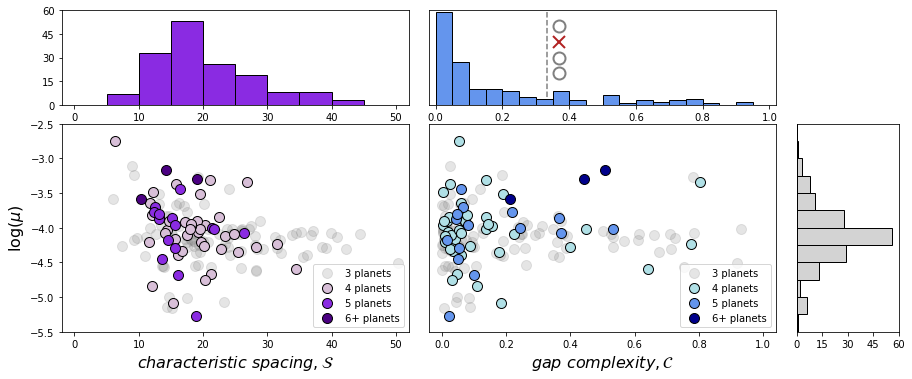

In [22]:
# S vs mu scatter plot
S_labels = [1,2,3,4,5,6,7,8]
S_ticks = np.log(S_labels)


plt.figure(figsize=(15,8))

ax1 = plt.subplot2grid((4,7),(2,0),colspan=3,rowspan=3)
plt.scatter(S[N==3], logmu[N==3], c='grey',   alpha=0.2,     s=100, label='3 planets')
plt.scatter(S[N==4], logmu[N==4], c='thistle', edgecolor='k', s=100, label='4 planets')
plt.scatter(S[N==5], logmu[N==5], c='blueviolet', edgecolor='k', s=100, label='5 planets')
plt.scatter(S[N>=6], logmu[N>=6], c='indigo', edgecolor='k', s=100, label='6+ planets')
plt.xlim(-2,52)
plt.xlabel(r'$characteristic\ spacing, \mathcal{S}$',fontsize=16)
plt.ylim(-5.5,-2.5)
plt.ylabel(r'$\log(\mu)$',fontsize=16)
plt.legend(loc='lower right',frameon=True)

# C vs mu scatter plot
ax2 = plt.subplot2grid((4,7),(2,3),colspan=3,rowspan=3)
plt.scatter(C[N==3], logmu[N==3], c='grey',           alpha=0.2,     s=100, label='3 planets')
plt.scatter(C[N==4], logmu[N==4], c='powderblue',     edgecolor='k', s=100, label='4 planets')
plt.scatter(C[N==5], logmu[N==5], c='cornflowerblue', edgecolor='k', s=100, label='5 planets')
plt.scatter(C[N>=6], logmu[N>=6], c='darkblue',       edgecolor='k', s=100, label='6+ planets')
plt.xlim(-0.04,1.04)
plt.xlabel(r'$gap\ complexity, \mathcal{C}$',fontsize=16)
plt.ylim(-5.5,-2.5)
plt.yticks([])
plt.legend(loc='lower right',frameon=True)


# S historgram
ax1h = plt.subplot2grid((4,7),(1,0),colspan=3,rowspan=1)
plt.hist(S[N>2], bins=np.arange(0.0,55.0,5.0), color='blueviolet', edgecolor='black')
plt.xlim(-2,52)
plt.ylim(0,60)
plt.yticks([0,15,30,45,60])


# C histogram
ax2h = plt.subplot2grid((4,7),(1,3),colspan=3,rowspan=1)
plt.hist(C[N>2], bins=np.arange(0.0,1.05,0.05), color='cornflowerblue', edgecolor='black')

plt.vlines(C43,0,60, color='grey', linestyle='--', zorder=0)
plt.plot([0.37,0.37,0.37], [20,30,50], 'o', c='grey', ms=12, fillstyle='none', mew=2)
plt.plot([0.37], [40], 'x', c='firebrick', ms=12, mew=2)

plt.xlim(-0.02,1.02)
plt.ylim(0,60)
plt.yticks([])

# mu historgram
axsh = plt.subplot2grid((4,7),(2,6),colspan=1,rowspan=3)
plt.hist(logmu[N>2],bins=np.arange(-5.5,-2.25,0.25), \
         orientation='horizontal',color='lightgrey',edgecolor='black')
plt.yticks([])
plt.ylim(-5.5,-2.5)
plt.xticks([0,15,30,45,60])
plt.xlim(0,60)

#plt.savefig('/Users/research/Desktop/Figures/spacing.pdf',bbox_inches='tight')
plt.show()

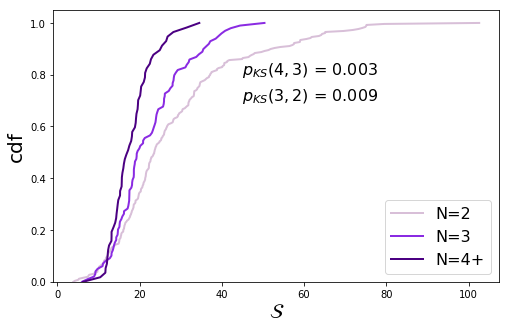

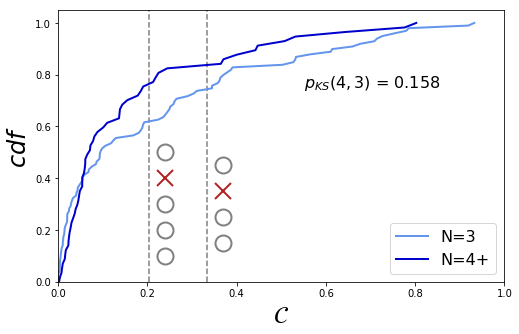

In [23]:
# plot S
plt.figure(figsize=(8,5))
plt.plot(S2,np.linspace(0,1,len(S2)), lw=2, color='thistle', label='N=2')
plt.plot(S3,np.linspace(0,1,len(S3)), lw=2, color='blueviolet',   label='N=3')
plt.plot(S4,np.linspace(0,1,len(S4)), lw=2, color='indigo',   label='N=4+')
plt.legend(loc='lower right', fontsize=16)
plt.xlabel('$\mathcal{S}$', fontsize=20)
plt.ylim(0,1.05)
plt.ylabel('cdf', fontsize=20)
plt.text(45,0.8, r'$p_{KS}(4,3)$ = %.3f' %KS_S43[1], fontsize=16, ha='left')
plt.text(45,0.7, r'$p_{KS}(3,2)$ = %.3f' %KS_S32[1], fontsize=16, ha='left')
plt.show()



# plot C
plt.figure(figsize=(8,5))
plt.plot(C3, np.linspace(0,1,len(C3)), lw=2, color='cornflowerblue', label='N=3')
plt.plot(C4, np.linspace(0,1,len(C4)), lw=2, color='mediumblue', label='N=4+')
plt.xlim(0,1)
plt.xlabel(r'$\mathcal{C}$', fontsize=24)
plt.ylim(0,1.05)
plt.ylabel(r'$cdf$', fontsize=24)

plt.vlines(C43,0,1.05, color='grey', linestyle='--', zorder=0)
plt.plot([0.37,0.37,0.37], [0.15,0.25,0.45], 'o', c='grey', ms=16, fillstyle='none', mew=2)
plt.plot(0.37, 0.35, 'x', c='firebrick', ms=16, mew=2)

plt.vlines(C54,0,1.05, color='grey', linestyle='--', zorder=0)
plt.plot([0.24,0.24,0.24,0.24], [0.1,0.2,0.3,0.5], 'o', c='grey', ms=16, fillstyle='none', mew=2)
plt.plot(0.24, 0.4, 'x', c='firebrick', ms=16, mew=2)

plt.text(0.55,0.75, r'$p_{KS}(4,3)$ = %.3f' %KS_C[1], fontsize=16, ha='left')
plt.legend(loc='lower right', fontsize=16)

plt.show()

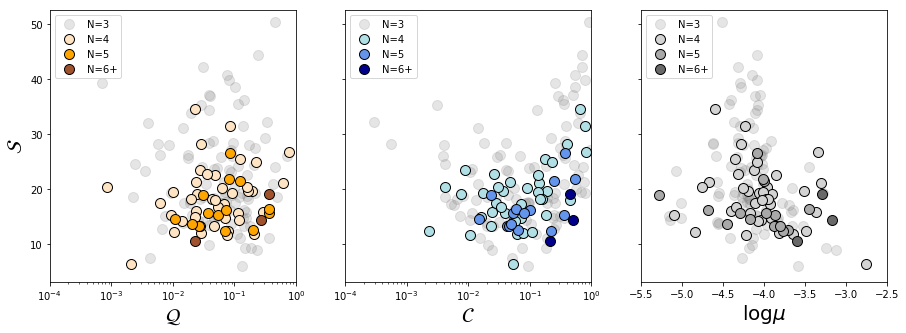

In [24]:
# compare Q, C, mu with S

fig, axes = plt.subplots(1,3, figsize=(15,5))

ax = axes[0]
ax.scatter(Q[N==3], S[N==3], s=100, color='grey', alpha=0.2, label='N=3')
ax.scatter(Q[N==4],  S[N==4],  s=100, color='bisque', edgecolor='k', label='N=4')
ax.scatter(Q[N==5],  S[N==5],  s=100, color='orange', edgecolor='k', label='N=5')
ax.scatter(Q[N>=6],  S[N>=6],  s=100, color='sienna', edgecolor='k', label='N=6+')
ax.set_ylabel(r'$\mathcal{S}$', fontsize=20)
ax.set_xscale('log')
ax.set_xlim(0.0001,1)
ax.set_xlabel(r'$\mathcal{Q}$', fontsize=20)
ax.legend(loc='upper left')

ax = axes[1]
ax.scatter(C[N==3], S[N==3], s=100, color='grey', alpha=0.2, label='N=3')
ax.scatter(C[N==4],  S[N==4],  s=100, color='powderblue',     edgecolor='k', label='N=4')
ax.scatter(C[N==5],  S[N==5],  s=100, color='cornflowerblue', edgecolor='k', label='N=5')
ax.scatter(C[N>=6],  S[N>=6],  s=100, color='darkblue',       edgecolor='k', label='N=6+')
ax.set_yticklabels([])
ax.set_xscale('log')
ax.set_xlim(0.0001,1)
ax.set_xlabel(r'$\mathcal{C}$', fontsize=20)
ax.legend(loc='upper left')

ax = axes[2]
ax.scatter(logmu[N==3], S[N==3], s=100, color='grey', alpha=0.2, label='N=3')
ax.scatter(logmu[N==4], S[N==4],  s=100, color='lightgrey', edgecolor='k', label='N=4')
ax.scatter(logmu[N==5], S[N==5],  s=100, color='darkgrey',  edgecolor='k', label='N=5')
ax.scatter(logmu[N>=6], S[N>=6],  s=100, color='dimgrey',   edgecolor='k', label='N=6+')
ax.set_yticklabels([])
ax.set_xlim(-5.5,-2.5)
ax.set_xlabel(r'$\log\mu$', fontsize=20)
ax.legend(loc='upper left')

#plt.savefig('/Users/research/Desktop/spacing_shadow.pdf', bbox_inches='tight')
plt.show()

# Results for $\mathcal{f}$

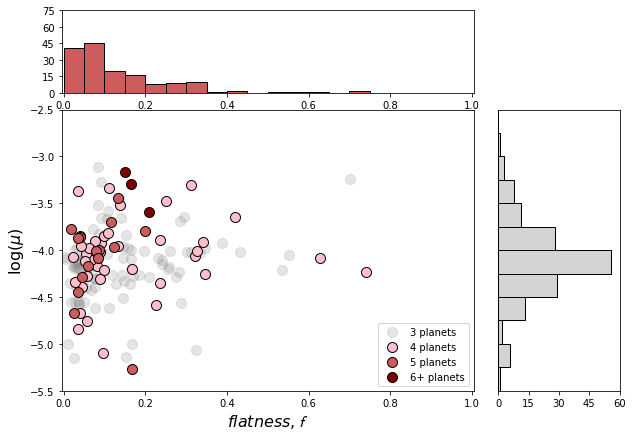

In [25]:
plt.figure(figsize=(10,7))
plt.tight_layout()

# f vs mu scatter plot
ax1 = plt.subplot2grid((4,4),(1,0),colspan=3,rowspan=3)
plt.scatter(f[N==3], logmu[N==3], c='grey',      alpha=0.2,     s=100, label='3 planets')
plt.scatter(f[N==4], logmu[N==4], c='pink',      edgecolor='k', s=100, label='4 planets')
plt.scatter(f[N==5], logmu[N==5], c='indianred', edgecolor='k', s=100, label='5 planets')
plt.scatter(f[N>=6], logmu[N>=6], c='maroon',    edgecolor='k', s=100, label='6+ planets')
plt.xlim(-0.005,1.005)
plt.xlabel(r'$flatness, \mathcal{f}$',fontsize=16)
plt.ylim(-5.5,-2.5)
plt.ylabel(r'$\log(\mu)$',fontsize=16)
plt.legend(loc='lower right',frameon=True)


# f historgram
ax1h = plt.subplot2grid((4,4),(0,0),colspan=3,rowspan=1)
plt.hist(f[N>=3], bins=np.arange(0.0,1.05,0.05), color='indianred', edgecolor='black')
plt.xlim(-0.005,1.005)
plt.ylim(0,75)
plt.yticks([0,15,30,45,60,75])


# mu historgram
axsh = plt.subplot2grid((4,4),(1,3),colspan=1,rowspan=3)
plt.hist(logmu[N>2],bins=np.arange(-5.5,-2.25,0.25), \
         orientation='horizontal',color='lightgrey',edgecolor='black')
plt.yticks([])
plt.ylim(-5.5,-2.5)
plt.xticks([0,15,30,45,60])
plt.xlim(0,60)

#plt.savefig('/Users/research/Desktop/flatness.pdf',bbox_inches='tight')
plt.show()

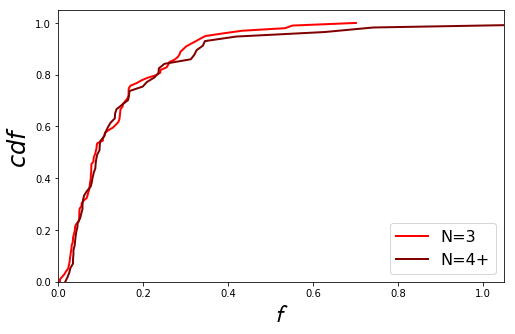

In [26]:
# plot f
f3 = np.sort(f[(N==3)*(f!=99)])
f4 = np.sort(f[(N>=4)*(f!=99)])

plt.figure(figsize=(8,5))
plt.plot(f3, np.linspace(0,1,len(f3)), lw=2, color='red', label='N=3')
plt.plot(f4, np.linspace(0,1,len(f4)), lw=2, color='maroon', label='N=4+')
plt.xlim(0,1.05)
plt.xlabel(r'$\mathcal{f}$', fontsize=24)
plt.ylim(0,1.05)
plt.ylabel(r'$cdf$', fontsize=24)
plt.legend(loc='lower right', fontsize=16)

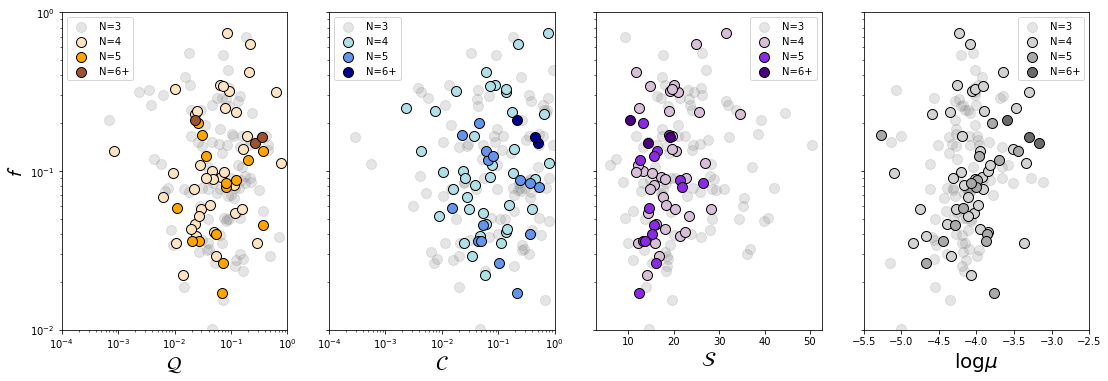

In [27]:
# compare Q, C, mu with f

use3 = (N==3)*(f!=99)
use4 = (N==4)*(f!=99)
use5 = (N==5)*(f!=99)
use6 = (N>=6)*(f!=99)


fig, axes = plt.subplots(1,4, figsize=(15,5))
plt.tight_layout()

ax = axes[0]
ax.scatter(Q[use3], f[use3], s=100, color='grey', alpha=0.2, label='N=3')
ax.scatter(Q[use4], f[use4], s=100, color='bisque', edgecolor='k', label='N=4')
ax.scatter(Q[use5], f[use5], s=100, color='orange', edgecolor='k', label='N=5')
ax.scatter(Q[use6], f[use6], s=100, color='sienna', edgecolor='k', label='N=6+')
ax.set_yscale('log')
ax.set_ylim(0.01,1)
ax.set_ylabel(r'$\mathcal{f}$', fontsize=20)
ax.set_xscale('log')
ax.set_xlim(0.0001,1)
ax.set_xlabel(r'$\mathcal{Q}$', fontsize=20)
ax.legend(loc='upper left')

ax = axes[1]
ax.scatter(C[use3], f[use3], s=100, color='grey', alpha=0.2, label='N=3')
ax.scatter(C[use4], f[use4], s=100, color='powderblue',     edgecolor='k', label='N=4')
ax.scatter(C[use5], f[use5], s=100, color='cornflowerblue', edgecolor='k', label='N=5')
ax.scatter(C[use6], f[use6], s=100, color='darkblue',       edgecolor='k', label='N=6+')
ax.set_yscale('log')
ax.set_ylim(0.01,1)
ax.set_yticklabels([])
ax.set_xscale('log')
ax.set_xlim(0.0001,1)
ax.set_xlabel(r'$\mathcal{C}$', fontsize=20)
ax.legend(loc='upper left')

ax = axes[2]
ax.scatter(S[use3], f[use3], s=100, color='grey', alpha=0.2, label='N=3')
ax.scatter(S[use4], f[use4], s=100, color='thistle', edgecolor='k', label='N=4')
ax.scatter(S[use5], f[use5], s=100, color='blueviolet',  edgecolor='k', label='N=5')
ax.scatter(S[use6], f[use6], s=100, color='indigo',   edgecolor='k', label='N=6+')
ax.set_yscale('log')
ax.set_ylim(0.01,1)
ax.set_yticklabels([])
ax.set_xlabel(r'$\mathcal{S}$', fontsize=20)
ax.legend(loc='upper right')

ax = axes[3]
ax.scatter(logmu[use3], f[use3], s=100, color='grey', alpha=0.2, label='N=3')
ax.scatter(logmu[use4], f[use4], s=100, color='lightgrey', edgecolor='k', label='N=4')
ax.scatter(logmu[use5], f[use5], s=100, color='darkgrey',  edgecolor='k', label='N=5')
ax.scatter(logmu[use6], f[use6], s=100, color='dimgrey',   edgecolor='k', label='N=6+')
ax.set_yscale('log')
ax.set_ylim(0.01,1)
ax.set_yticklabels([])
ax.set_xlim(-5.5,-2.5)
ax.set_xlabel(r'$\log\mu$', fontsize=20)
ax.legend(loc='upper right')

#plt.savefig('/Users/research/Desktop/flatness_shadow.pdf', bbox_inches='tight')
plt.show()

# Monotonicity $\mathcal{M}$

In [28]:
M3 = M[N==3]
M2 = M[N==2]
M4 = M[N>=4]

M2 = np.sort(np.squeeze(M2))
M3 = np.sort(np.squeeze(M3))
M4 = np.sort(np.squeeze(M4))


KS_M32 = np.array(stats.ks_2samp(M3,M2))
KS_M43 = np.array(stats.ks_2samp(M4,M3))


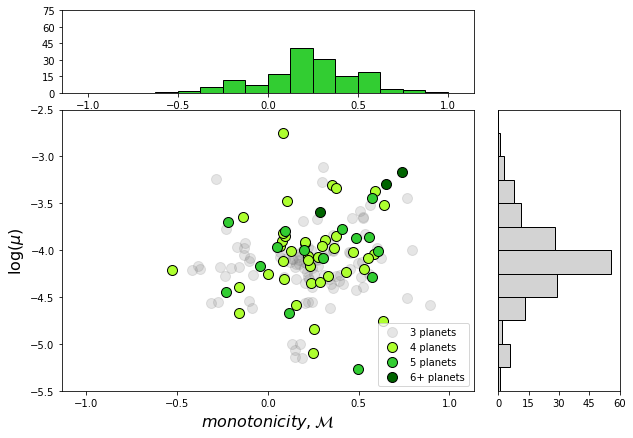

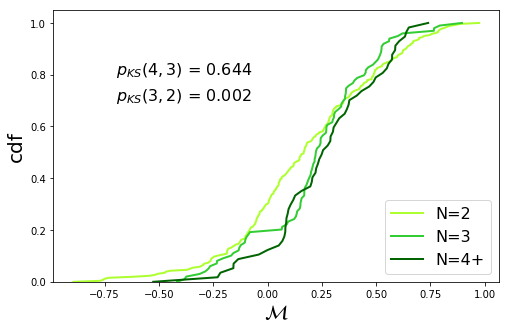

In [29]:
plt.figure(figsize=(10,7))
plt.tight_layout()

# M vs mu scatter plot
ax1 = plt.subplot2grid((4,4),(1,0),colspan=3,rowspan=3)
plt.scatter(M[N==3], logmu[N==3], c='grey',   alpha=0.2,     s=100, label='3 planets')
plt.scatter(M[N==4], logmu[N==4], c='greenyellow', edgecolor='k', s=100, label='4 planets')
plt.scatter(M[N==5], logmu[N==5], c='limegreen', edgecolor='k', s=100, label='5 planets')
plt.scatter(M[N>=6], logmu[N>=6], c='darkgreen', edgecolor='k', s=100, label='6+ planets')
plt.xlim(-1.135,1.135)
plt.xlabel(r'$monotonicity, \mathcal{M}$',fontsize=16)
plt.ylim(-5.5,-2.5)
plt.ylabel(r'$\log(\mu)$',fontsize=16)
plt.legend(loc='lower right',frameon=True)


# M historgram
ax1h = plt.subplot2grid((4,4),(0,0),colspan=3,rowspan=1)
plt.hist(M[N>2], bins=np.arange(-1.0,1.125,0.125), color='limegreen', edgecolor='black')
plt.xlim(-1.145,1.145)
plt.ylim(0,75)
plt.yticks([0,15,30,45,60,75])


# mu historgram
axsh = plt.subplot2grid((4,4),(1,3),colspan=1,rowspan=3)
plt.hist(logmu[N>2],bins=np.arange(-5.5,-2.25,0.25), \
         orientation='horizontal',color='lightgrey',edgecolor='black')
plt.yticks([])
plt.ylim(-5.5,-2.5)
plt.xticks([0,15,30,45,60])
plt.xlim(0,60)

#plt.savefig('/Users/research/Desktop/monotonicity.pdf',bbox_inches='tight')
plt.show()


# plot cdf
plt.figure(figsize=(8,5))
plt.plot(M2,np.linspace(0,1,len(M2)), lw=2, color='greenyellow', label='N=2')
plt.plot(M3,np.linspace(0,1,len(M3)), lw=2, color='limegreen',   label='N=3')
plt.plot(M4,np.linspace(0,1,len(M4)), lw=2, color='darkgreen',   label='N=4+')
plt.legend(loc='lower right', fontsize=16)
plt.xlabel('$\mathcal{M}$', fontsize=20)
plt.ylim(0,1.05)
plt.ylabel('cdf', fontsize=20)
plt.text(-0.7,0.8, r'$p_{KS}(4,3)$ = %.3f' %KS_M43[1], fontsize=16, ha='left')
plt.text(-0.7,0.7, r'$p_{KS}(3,2)$ = %.3f' %KS_M32[1], fontsize=16, ha='left')
plt.show()

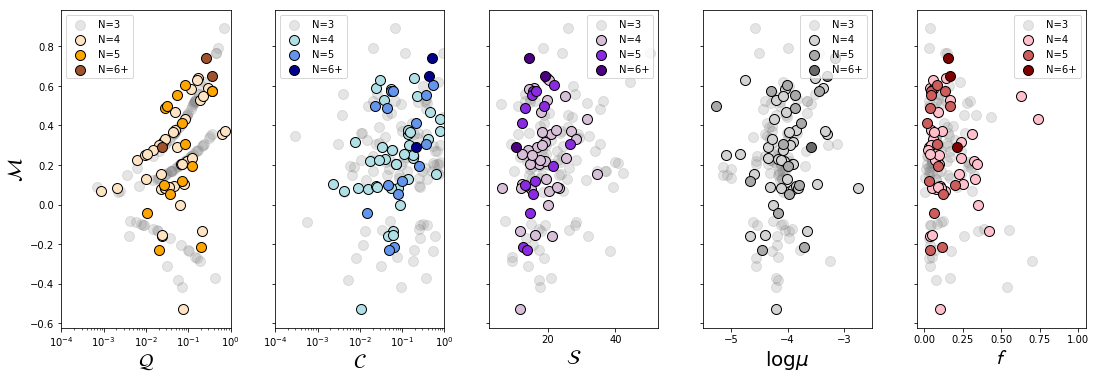

In [30]:
# compare Q, C, S, f with M

use3 = (N==3)*(f!=99)
use4 = (N==4)*(f!=99)
use5 = (N==5)*(f!=99)
use6 = (N>=6)*(f!=99)


fig, axes = plt.subplots(1,5, figsize=(15,5))

plt.tight_layout()

ax = axes[0]
ax.scatter(Q[use3], M[use3], s=100, color='grey', alpha=0.2, label='N=3')
ax.scatter(Q[use4], M[use4], s=100, color='bisque', edgecolor='k', label='N=4')
ax.scatter(Q[use5], M[use5], s=100, color='orange', edgecolor='k', label='N=5')
ax.scatter(Q[use6], M[use6], s=100, color='sienna', edgecolor='k', label='N=6+')
ax.set_ylabel(r'$\mathcal{M}$', fontsize=20)
ax.set_xscale('log')
ax.set_xlim(0.0001,1)
ax.set_xlabel(r'$\mathcal{Q}$', fontsize=20)
ax.legend(loc='upper left')

ax = axes[1]
ax.scatter(C[use3], M[use3], s=100, color='grey', alpha=0.2, label='N=3')
ax.scatter(C[use4], M[use4], s=100, color='powderblue',     edgecolor='k', label='N=4')
ax.scatter(C[use5], M[use5], s=100, color='cornflowerblue', edgecolor='k', label='N=5')
ax.scatter(C[use6], M[use6], s=100, color='darkblue',       edgecolor='k', label='N=6+')
ax.set_yticklabels([])
ax.set_xscale('log')
ax.set_xlim(0.0001,1)
ax.set_xlabel(r'$\mathcal{C}$', fontsize=20)
ax.legend(loc='upper left')

ax = axes[2]
ax.scatter(S[use3], M[use3], s=100, color='grey', alpha=0.2, label='N=3')
ax.scatter(S[use4], M[use4], s=100, color='thistle', edgecolor='k', label='N=4')
ax.scatter(S[use5], M[use5], s=100, color='blueviolet',  edgecolor='k', label='N=5')
ax.scatter(S[use6], M[use6], s=100, color='indigo',   edgecolor='k', label='N=6+')
ax.set_yticklabels([])
#ax.set_xticks(S_ticks)
#ax.set_xticklabels(S_labels)
ax.set_xlabel(r'$\mathcal{S}$', fontsize=20)
ax.legend(loc='upper right')

ax = axes[3]
ax.scatter(logmu[use3], M[use3], s=100, color='grey', alpha=0.2, label='N=3')
ax.scatter(logmu[use4], M[use4], s=100, color='lightgrey', edgecolor='k', label='N=4')
ax.scatter(logmu[use5], M[use5], s=100, color='darkgrey',  edgecolor='k', label='N=5')
ax.scatter(logmu[use6], M[use6], s=100, color='dimgrey',   edgecolor='k', label='N=6+')
ax.set_yticklabels([])
ax.set_xlim(-5.5,-2.5)
ax.set_xlabel(r'$\log\mu$', fontsize=20)
ax.legend(loc='upper right')

ax = axes[4]
ax.scatter(f[use3], M[use3], s=100, color='grey', alpha=0.2, label='N=3')
ax.scatter(f[use4], M[use4], s=100, color='pink', edgecolor='k', label='N=4')
ax.scatter(f[use5], M[use5], s=100, color='indianred',  edgecolor='k', label='N=5')
ax.scatter(f[use6], M[use6], s=100, color='maroon',   edgecolor='k', label='N=6+')
ax.set_yticklabels([])
ax.set_xlim(-0.05,1.05)
ax.set_xlabel(r'$\mathcal{f}$', fontsize=20)
ax.legend(loc='upper right')

#plt.savefig('/Users/research/Desktop/compare_to_M.pdf', bbox_inches='tight')

plt.show()

# Clustering algorithms w/ scikit-learn spectral

In [31]:
use = (f<1.0)*(N>2)

# these are the variables to run clustering on
mukm = np.log10(mu[use])
Qkm  = Q[use]
Ckm  = C[use]
Skm  = S[use]
fkm  = f[use]
Mkm  = M[use]

mu_N_km = np.log10(mu[use]/N[use])

# track N but don't cluster with it
Nkm  = N[use]

n_systems = np.sum(use)

In [32]:
# build data array
data   = np.vstack([mukm, Qkm, Ckm, Skm, fkm])
labels = ['logmu', 'Q', 'C', 'S', 'f']

n_data = len(data)

# save raw (unscaled) data
rawdata = data.copy()
rawdata = rawdata.swapaxes(0,1)

# scale each variable to range (0,1) to evenly weight clustering
for i in range(n_data):
    data[i] = data[i]/(data[i].max()-data[i].min())
    
data = data.swapaxes(0,1)

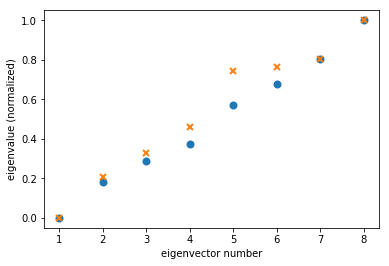

In [33]:
# define n_clusters and n_neighbors for kNN clustering
n_clusters = 4

n_neighbors_low  = int(1+np.round(np.log2(n_systems)))
n_neighbors_high = int(n_systems/np.log2(n_systems))
n_neighbors_list = [n_neighbors_low, n_neighbors_high]

# set up figure
plt.figure()
plt.xlabel('eigenvector number')
plt.ylabel('eigenvalue (normalized)')

marker = ['o', 'x']

# do eigenvector analysis
for i, n_neighbors in enumerate(n_neighbors_list):
    # set up spectral clustering model
    sc = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', n_neighbors=n_neighbors)    
    cluster_fit = sc.fit_predict(data)

    # construct affinity matrix (A), adjacency matrix (W), degree matrix (D), and graph laplacian (L)
    A = sc.affinity_matrix_.toarray()
    W = A - np.eye(n_systems)
    D = np.diag(W.sum(axis=1))
    L = D - W

    # normalize graph laplacian (symmetric method)
    D12   = np.linalg.inv(np.sqrt(D))
    Lnorm = np.dot(np.dot(D12,L),D12)

    # get eigenvectors & eigenvalues
    lam, v = np.linalg.eig(Lnorm)

    order = np.argsort(lam)
    lam = lam[order]
    v   = v[:,order]

    plt.plot(np.arange(1,1+n_neighbors_low), lam[:n_neighbors_low]/np.max(lam[:n_neighbors_low]), \
             marker=marker[i], mew=2, ls='none')

plt.show()

In [34]:
for i in range(len(labels)):
    print('\n%s' %labels[i])
    for j in range(n_clusters):
        print('%.3f +/- %.3f' %(np.median(rawdata[:,i][cluster_fit==j]), \
                                 astropy.stats.mad_std(rawdata[:,i][cluster_fit==j])))
        
print('\n---------------\n')
print('N')
for j in range(n_clusters):
    x = np.sum(Nkm[cluster_fit==j]==3)/np.sum(Nkm[cluster_fit==j]>=3)
    print('3-fraction = %.3f' %x)


logmu
-3.966 +/- 0.285
-4.117 +/- 0.153
-4.396 +/- 0.250
-4.017 +/- 0.171

Q
0.100 +/- 0.098
0.071 +/- 0.063
0.036 +/- 0.031
0.067 +/- 0.056

C
0.072 +/- 0.085
0.532 +/- 0.239
0.031 +/- 0.034
0.053 +/- 0.060

S
15.633 +/- 3.818
28.819 +/- 9.908
18.881 +/- 6.460
19.151 +/- 3.725

f
0.081 +/- 0.059
0.106 +/- 0.094
0.055 +/- 0.036
0.323 +/- 0.094

---------------

N
3-fraction = 0.492
3-fraction = 0.818
3-fraction = 0.718
3-fraction = 0.636


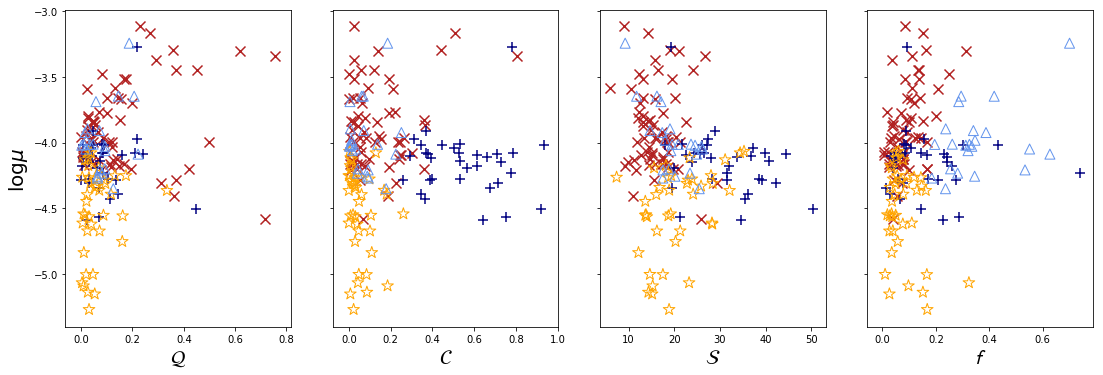

In [35]:
# compare Q, C, S, f vs logmu
colors = ['firebrick', 'navy', 'orange', 'cornflowerblue', 'purple', 'red']
markers = ['x', '+', '*', '^', 'd', 's']
msize   = [100, 100, 150, 100, 100, 100]
facecolors = ['firebrick', 'navy', 'none', 'none', 'none', 'none']


fig, axes = plt.subplots(1,4, figsize=(15,5))
plt.tight_layout()

ax = axes[0]
for i in range(n_clusters):
    ax.scatter(Qkm[cluster_fit==i], mukm[cluster_fit==i], s=msize[i], color=colors[i], marker=markers[i], \
               facecolors=facecolors[i])
ax.set_xlabel(r'$\mathcal{Q}$', fontsize=20)
ax.set_ylabel(r'$\log\mu$', fontsize=20)

ax = axes[1]
for i in range(n_clusters):
    ax.scatter(Ckm[cluster_fit==i], mukm[cluster_fit==i], s=msize[i], color=colors[i], marker=markers[i], \
               facecolors=facecolors[i])
ax.set_xlabel(r'$\mathcal{C}$', fontsize=20)
ax.set_ylabel('')
ax.set_yticklabels([])

ax = axes[2]
for i in range(n_clusters):
    ax.scatter(Skm[cluster_fit==i], mukm[cluster_fit==i], s=msize[i], color=colors[i], marker=markers[i], \
               facecolors=facecolors[i])
ax.set_xlabel(r'$\mathcal{S}$', fontsize=20)
ax.set_ylabel('')
ax.set_yticklabels([])

ax = axes[3]
for i in range(n_clusters):
    ax.scatter(fkm[cluster_fit==i], mukm[cluster_fit==i], s=msize[i], color=colors[i], marker=markers[i], \
               facecolors=facecolors[i])
ax.set_xlabel(r'$\mathcal{f}$', fontsize=20)
ax.set_ylabel('')
ax.set_yticklabels([])

#plt.savefig('/Users/research/Desktop/clustered_X_vs_logmu.pdf', bbox_inches='tight')
plt.show()

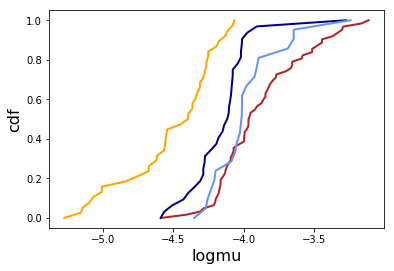

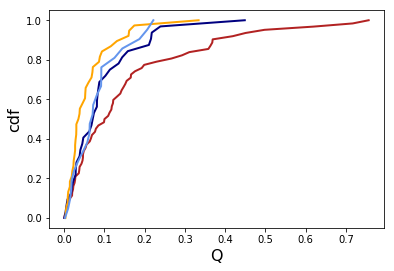

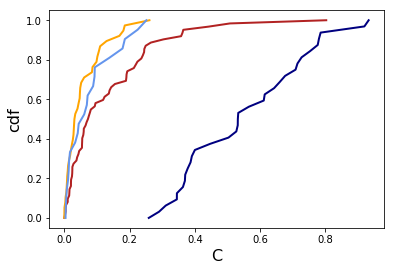

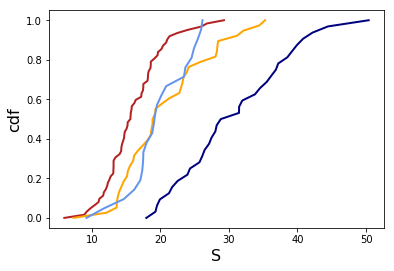

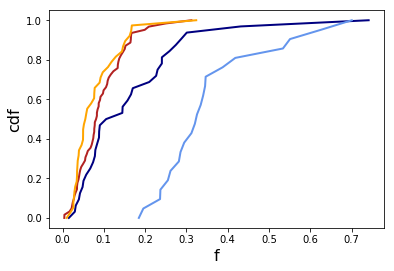

In [36]:
for i in range(len(labels)):
    plt.figure()
    plt.xlabel(labels[i], fontsize=16)
    plt.ylabel('cdf', fontsize=16)
    for j in range(n_clusters):
        x = np.sort(rawdata[:,i][cluster_fit==j])
        plt.plot(x, np.linspace(0,1,len(x)), color=colors[j], lw=2)
    plt.show()

# Scratchwork

In [37]:
# build data array
data   = np.vstack([mukm, Qkm, Ckm, Skm, fkm])
labels = ['logmu', 'Q', 'C', 'S', 'f']

n_data = len(data)

# save raw (unscaled) data
rawdata = data.copy()
rawdata = rawdata.swapaxes(0,1)

# scale each variable to range (0,1) to evenly weight clustering
for i in range(n_data):
    data[i] = data[i]/(data[i].max()-data[i].min())

data = data.swapaxes(0,1)

In [38]:
def make_similarity_matrix(data, sigma):
    eucDM = DistanceMetric.get_metric('euclidean')
    xij   = eucDM.pairwise(data)
    sij   = np.exp(-xij**2/(2*sigma**2)) - np.eye(len(data))
    
    return sij



def make_robust_similarity_matrix(sij, kNN):
    return None
        



def make_graph_laplacian(sij, norm=True):
    W = sij * (1 - np.eye(n_systems))
    D = np.diag(W.sum(axis=1))

    if norm == False:
        return D - W
    
    else:
        D12 = np.linalg.inv(np.sqrt(D))
        return np.dot(np.dot(D12,D-W),D12)

In [ ]:
# set the number of clusters
n_clusters = 3


# optimize sigma by minimizing distortion
sigma_list  = np.linspace(0.25,2.0,100)
distortion  = np.zeros_like(sigma_list)

for n, sigma in enumerate(sigma_list):
    sij = make_similarity_matrix(data, sigma)    
    L   = make_graph_laplacian(sij)
    
    lam, v = np.linalg.eig(L)
    order  = np.argsort(lam)
    lam    = lam[order]
    v      = v[:,order]
    
    X = v[:,:n_clusters]
    Y = np.zeros_like(X)
    
    for i in range(n_systems):
        Y[i] = X[i]/np.sqrt(np.sum(X[i]**2))        
    
    km = KMeans(n_clusters=n_clusters)
    km_fit = km.fit_predict(Y)
    
    distortion[n] = km.inertia_


best_sigma = sigma_list[np.argmin(distortion)]

plt.figure(figsize=(5,3))
plt.plot(sigma_list, distortion, c='yellowgreen', mec='k')
plt.text(best_sigma, np.median(distortion), r'$\sigma = $ %.3f' %best_sigma, fontsize=16)
plt.show()




# make similarity matrix and graph Laplacian
sij = make_similarity_matrix(data, sigma=best_sigma)
L   = make_graph_laplacian(sij)
    

# get eigenvectors & eigenvalues; put in order
lam, v = np.linalg.eig(L)
order  = np.argsort(lam)
lam    = lam[order]
v      = v[:,order]



# plot the first 2n eigenvalues
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,1+2*n_clusters), lam[:2*n_clusters], marker='x', mew=2, ms=12, ls='none', color='yellowgreen')
plt.show()

# plot the first n eigenvectors
fig, axes = plt.subplots(1,n_clusters, figsize=(18,3))
for i in range(n_clusters):
    axes[i].plot(v[:,i], color='green')
    axes[i].set_xticklabels('')
    axes[i].set_yticklabels('')
            
# run kmeans on the eigenvectors
km = KMeans(n_clusters=n_clusters)
km_fit = km.fit_predict(v[:,:n_clusters])


# plot clusters in eigenspace
n_subplots = np.max([1,int(n_clusters*(n_clusters-1)/2)])
fig, axes = plt.subplots(1, n_subplots, figsize=(18,3))

ij = 0
for i in range(n_clusters):
    for j in range(n_clusters):
        if i < j:
            if n_subplots > 1: ax = axes[ij]
            else: ax = axes
            ax.plot(v[:,i], v[:,j], '.', c='darkmagenta')
            ax.set_xticklabels('')
            ax.set_yticklabels('')
            ij += 1

plt.show()

In [ ]:
# now do the clustering with sklearn
sc = SpectralClustering(n_clusters=n_clusters, affinity='precomputed')    
sc_fit = sc.fit_predict(sij)

# make some plots to compare Q, C, S, f vs logmu
colors = ['yellowgreen', 'gold', 'darkgreen', 'darkmagenta', 'red', 'grey']
markers = ['x', '+', '*', '^', 'd', 's']
msize   = [100, 100, 150, 100, 100, 100]
facecolors = ['yellowgreen', 'gold', 'none', 'none', 'none', 'none']


fig, axes = plt.subplots(1,4, figsize=(15,5))
plt.tight_layout()

ax = axes[0]
for i in range(n_clusters):
    ax.scatter(Qkm[sc_fit==i], mukm[sc_fit==i], s=msize[i], color=colors[i], marker=markers[i], \
               facecolors=facecolors[i])
ax.set_xlabel(r'$\mathcal{Q}$', fontsize=20)
ax.set_ylabel(r'$\log\mu$', fontsize=20)

ax = axes[1]
for i in range(n_clusters):
    ax.scatter(Ckm[sc_fit==i], mukm[sc_fit==i], s=msize[i], color=colors[i], marker=markers[i], \
               facecolors=facecolors[i])
ax.set_xlabel(r'$\mathcal{C}$', fontsize=20)
ax.set_ylabel('')
ax.set_yticklabels([])

ax = axes[2]
for i in range(n_clusters):
    ax.scatter(Skm[sc_fit==i], mukm[sc_fit==i], s=msize[i], color=colors[i], marker=markers[i], \
               facecolors=facecolors[i])
ax.set_xlabel(r'$\mathcal{S}$', fontsize=20)
ax.set_ylabel('')
ax.set_yticklabels([])

ax = axes[3]
for i in range(n_clusters):
    ax.scatter(fkm[sc_fit==i], mukm[sc_fit==i], s=msize[i], color=colors[i], marker=markers[i], \
               facecolors=facecolors[i])
ax.set_xlabel(r'$\mathcal{f}$', fontsize=20)
ax.set_ylabel('')
ax.set_yticklabels([])

#plt.savefig('/Users/research/Desktop/clustered_X_vs_logmu.pdf', bbox_inches='tight')
plt.show()

# Downsampling to make synthetic 3-planet catalogue

In [ ]:
s = systems[0]

a = P_to_a(s.periods, s.Mstar)
tp = transit_prob(a, s.Rstar)

i = 0
loop = True
while loop:
    rn   = np.random.uniform(size=len(tp))
    keep = tp > rn
    
    if sum(keep) > 0:
        loop = False
    else:
        i += 1

In [ ]:
sys3 = []
sys4 = []

# pull 3- and 4- planet systems
for i, s in enumerate(systems):
    if s.N == 3:
        sys3.append(s)
    elif s.N >= 4:
        sys4.append(s)
        

synthetic3 = []

while len(synthetic3) < len(sys3):
    draw_sys4 = np.random.choice(sys4)
    
    a  = P_to_a(draw_sys4.periods, draw_sys4.Mstar)
    tp = transit_prob(a, draw_sys4.Rstar)
    
    i = 0
    loop = True
    while loop:
        i += 1
        
        rn   = np.random.uniform(size=len(tp))
        keep = tp > rn
    
        if np.sum(keep) == 3:
            s = System()
            
            # downsample to create synthetic system
            s.sysid = len(synthetic3)
            s.Mstar = draw_sys4.Mstar
            s.Rstar = draw_sys4.Rstar
            
            s.rprs    = draw_sys4.rprs[keep]
            s.masses  = draw_sys4.masses[keep]
            s.periods = draw_sys4.periods[keep]
            
            # calculate N, mu, & Q
            s.N =  3
            s.mu = np.sum(s.masses)/s.Mstar/MSME
            s.Q = LMC.D(s.masses/np.sum(s.masses))
            
            # calculate C
            P   = s.periods
            pp  = np.log(P[1:]/P[:-1])/np.log(P.max()/P.min())
            s.C = np.squeeze(LMC.C(pp))
            
            # calculate Hill spacing
            P = s.periods
            a = P_to_a(P, s.Mstar)
            m = s.masses

            radius_H = ((m[1:]+m[:-1])/(3*s.Mstar*MSME))**(1/3) * (a[1:]+a[:-1])/2
            delta_H  = (a[1:]-a[:-1])/radius_H

            # calculate S:
            #s.S = np.log(P.max()/P.min())/(s.N-1)
            s.S = np.mean(delta_H)

            # add to list of synthetic 3-planet systems
            synthetic3.append(s)
            loop = False
            
        if i > len(sys4):
            loop = False

In [ ]:
xQ = []
xlogmu = []
for i, s in enumerate(synthetic3):
    xQ.append(s.Q)
    xlogmu.append(np.log10(s.mu))

xQ = np.array(xQ)
xlogmu = np.array(xlogmu)

    
plt.figure(figsize=(10,7))
plt.tight_layout()


# Q vs mu scatter plot
ax1 = plt.subplot2grid((4,4),(1,0),colspan=3,rowspan=3)
plt.scatter(xQ, xlogmu, c='grey', alpha=0.3, s=100, label='synthetic systems')
plt.scatter(Q[N==3], logmu[N==3], c='orange', edgecolor='k', s=100, marker='+', label='real systems')
plt.xlim(-0.02,1.02)
plt.xlabel(r'$mass\ partitioning, \mathcal{Q}$',fontsize=16)
plt.ylim(-5.5,-2.5)
plt.ylabel(r'$\log(\mu)$',fontsize=16)
plt.legend(loc='lower right',frameon=True)


# Q historgram
ax1h = plt.subplot2grid((4,4),(0,0),colspan=3,rowspan=1)
plt.hist(xQ, bins=np.arange(0.0,1.05,0.05), color='lightgrey', edgecolor='black')
plt.xlim(-0.02,1.02)
#plt.ylim(0,75)
#plt.yticks([0,15,30,45,60,75])


# mu historgram
axsh = plt.subplot2grid((4,4),(1,3),colspan=1,rowspan=3)
plt.hist(xlogmu,bins=np.arange(-5.5,-2.25,0.25), \
         orientation='horizontal',color='lightgrey',edgecolor='black')
plt.yticks([])
plt.ylim(-5.5,-2.5)
#plt.xticks([0,15,30,45,60])
#plt.xlim(0,60)

plt.show()


# plot Q cdf
fig, ax = plt.subplots(1, figsize=(8,5))
ax.plot(np.sort(xQ), np.linspace(0,1,len(xQ)), lw=2, color='grey', label='synthetic systems')
ax.plot(Q3, np.linspace(0,1,len(Q3)), lw=2, color='orange', label='real systems')
ax.set_xlim(0,1)
ax.set_xlabel(r'$\mathcal{Q}$', fontsize=24)
ax.set_ylim(0,1.05)
ax.set_ylabel(r'$cdf$', fontsize=24)

#ax.text(0.55,0.85, r'$p_{KS}(3,2)$ = %.3f' %KS_Q32[1], fontsize=16, ha='left')
ax.legend(loc='lower right', fontsize=16)

In [ ]:
xS = []
xC = []
xlogmu = []
for i, s in enumerate(synthetic3):
    xS.append(s.S)
    xC.append(s.C)
    xlogmu.append(np.log10(s.mu))

xS = np.array(xS)
xC = np.array(xC)
xlogmu = np.array(xlogmu)


# KS tests
KS_xS = stats.ks_2samp(xS, S[N==3])
KS_xC = stats.ks_2samp(xC, C[N==3])


# make figure
plt.figure(figsize=(15,8))

ax1 = plt.subplot2grid((4,7),(2,0),colspan=3,rowspan=3)
plt.scatter(xS, xlogmu, c='grey', alpha=0.3, s=100, label='synthetic systems')
plt.scatter(S[N==3], logmu[N==3], c='blueviolet', edgecolor='k', s=100, marker='+', label='real systems')
plt.xlabel(r'$characteristic\ spacing, \mathcal{S}$',fontsize=16)
plt.xlim(0,55)
plt.ylim(-5.5,-2.5)
plt.ylabel(r'$\log(\mu)$',fontsize=16)
plt.legend(loc='lower right',frameon=True)

# C vs mu scatter plot
ax2 = plt.subplot2grid((4,7),(2,3),colspan=3,rowspan=3)
plt.scatter(xC, xlogmu, c='grey', alpha=0.3, s=100, label='synthetic systems')
plt.scatter(C[N==3], logmu[N==3], c='cornflowerblue', edgecolor='k', s=100, marker='+', label='real systems')
plt.xlim(-0.04,1.04)
plt.xlabel(r'$gap\ complexity, \mathcal{C}$',fontsize=16)
plt.ylim(-5.5,-2.5)
plt.yticks([])
plt.legend(loc='lower right',frameon=True)


# S historgram
ax1h = plt.subplot2grid((4,7),(1,0),colspan=3,rowspan=1)
plt.hist(xS, bins=np.arange(0.,55.,5.), color='lightgrey', edgecolor='black')
plt.xlim(0,55)
plt.ylim(0,60)
plt.yticks([0,15,30,45,60])


# C histogram
ax2h = plt.subplot2grid((4,7),(1,3),colspan=3,rowspan=1)
plt.hist(xC, bins=np.arange(0.0,1.05,0.05), color='lightgrey', edgecolor='black')

plt.vlines(C43,0,60, color='grey', linestyle='--', zorder=0)
plt.plot([0.37,0.37,0.37], [20,30,50], 'o', c='grey', ms=12, fillstyle='none', mew=2)
plt.plot([0.37], [40], 'x', c='firebrick', ms=12, mew=2)

plt.xlim(-0.02,1.02)
plt.ylim(0,60)
plt.yticks([])

# mu historgram
axsh = plt.subplot2grid((4,7),(2,6),colspan=1,rowspan=3)
plt.hist(xlogmu,bins=np.arange(-5.5,-2.25,0.25), \
         orientation='horizontal',color='lightgrey',edgecolor='black')
plt.yticks([])
plt.ylim(-5.5,-2.5)
#plt.xticks([0,15,30,45,60])
#plt.xlim(0,60)

plt.show()


# plot S cdf
plt.figure(figsize=(8,5))
plt.plot(np.sort(xS),np.linspace(0,1,len(xS)), lw=2, color='grey',   label='synthetic systems')
plt.plot(S3,np.linspace(0,1,len(S3)), lw=2, color='blueviolet',   label='real systems')
plt.legend(loc='lower right', fontsize=16)
plt.xlabel('characteristic spacing', fontsize=20)
plt.ylim(0,1.05)
plt.ylabel('cdf', fontsize=20)
plt.text(30,0.7, r'$p_{KS}$ = %.3f' %KS_xS[1], fontsize=16, ha='left')
plt.show()



# plot C cdf
fig, ax = plt.subplots(1, figsize=(8,5))
ax.plot(np.sort(xC), np.linspace(0,1,len(xC)), lw=2, color='grey', label='synthetic systems')
ax.plot(C3, np.linspace(0,1,len(C3)), lw=2, color='cornflowerblue', label='real systems')
ax.set_xlim(0,1)
ax.set_xlabel(r'$\mathcal{C}$', fontsize=24)
ax.set_ylim(0,1.05)
ax.set_ylabel(r'$cdf$', fontsize=24)

ax.vlines(C43,0,1.05, color='grey', linestyle='--', zorder=0)
ax.plot([0.37,0.37,0.37], [0.15,0.25,0.45], 'o', c='grey', ms=16, fillstyle='none', mew=2)
ax.plot(0.37, 0.35, 'x', c='firebrick', ms=16, mew=2)

ax.vlines(C54,0,1.05, color='grey', linestyle='--', zorder=0)
ax.plot([0.24,0.24,0.24,0.24], [0.1,0.2,0.3,0.5], 'o', c='grey', ms=16, fillstyle='none', mew=2)
ax.plot(0.24, 0.4, 'x', c='firebrick', ms=16, mew=2)
ax.text(0.55,0.75, r'$p_{KS}$ = %.3f' %KS_xC[1], fontsize=16, ha='left')
ax.legend(loc='lower right', fontsize=16)

In [ ]:
# compare Q, C, mu with S
fig, axes = plt.subplots(1,3, figsize=(15,5))

ax = axes[0]
ax.scatter(xQ, xS, s=100, color='grey', alpha=0.3, label='synthetic')
ax.scatter(Q[N==3],  S[N==3],  s=100, marker='+', color='orange', label='real')
ax.set_ylabel(r'$\mathcal{S}$', fontsize=20)
ax.set_xscale('log')
ax.set_xlim(0.0001,1)
ax.set_xlabel(r'$\mathcal{Q}$', fontsize=20)
ax.legend(loc='upper left')

ax = axes[1]
ax.scatter(xC, xS, s=100, color='grey', alpha=0.3, label='synthetic')
ax.scatter(C[N==3],  S[N==3],  s=100, marker='+', color='cornflowerblue', label='real')
ax.set_yticklabels([])
ax.set_xscale('log')
ax.set_xlim(0.0001,1)
ax.set_xlabel(r'$\mathcal{C}$', fontsize=20)
ax.legend(loc='upper left')

ax = axes[2]
ax.scatter(xlogmu, xS, s=100, color='grey', alpha=0.3, label='synthetic')
ax.scatter(logmu[N==3], S[N==3],  s=100, marker='+',  color='black', label='real')
ax.set_yticklabels([])
ax.set_xlim(-5.5,-2.5)
ax.set_xlabel(r'$\log\mu$', fontsize=20)
ax.legend(loc='upper left')

#plt.savefig('/Users/research/Desktop/spacing_shadow.pdf', bbox_inches='tight')
plt.show()